In [1]:
###################################################################################################
#
# Copyright (C) 2022 Maxim Integrated Products, Inc. All Rights Reserved.
#
# Maxim Integrated Products, Inc. Default Copyright Notice:
# https://www.maximintegrated.com/en/aboutus/legal/copyrights.html
#
###################################################################################################

## IMPORTS
import os
import sys
import datetime
import time

import importlib
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from pathlib import Path
from collections import OrderedDict

import distiller

## FOR TENSOR BOARD
try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

## PATH FOR MODELS AND DATASET
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'models'))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'datasets'))

from unetnilm.metrics import get_results_summary, example_f1_score
from datasets import nilm2
import ai8x
import parse_qat_yaml

%matplotlib inline

msglogger = None

In [2]:
from enum import Enum, auto

In [3]:
class NilmModel(Enum):
    AUTOENCODER = auto()
    SEQ2POINT = auto()
    RESNET = auto()
    RESNET_WITH_BOTTLENECK = auto()
    SLIDINGWINDOW_RESNET = auto()

In [4]:
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

### Variables

In [5]:
TRAINING_DIR = Path.cwd().parent
MODEL = NilmModel.SLIDINGWINDOW_RESNET

if MODEL == NilmModel.AUTOENCODER:
        CHECKPOINT = Path.cwd().parent / "logs" / "2024.05.15-011246"
elif MODEL == NilmModel.SEQ2POINT:
        CHECKPOINT = Path.cwd().parent / "logs" / "2024.05.21-170228"
elif MODEL == NilmModel.RESNET:
        CHECKPOINT = Path.cwd().parent / "logs" / "2024.06.07-102716"
elif MODEL == NilmModel.RESNET_WITH_BOTTLENECK:
        CHECKPOINT = Path.cwd().parent / "logs" / "2024.06.06-125708"
elif MODEL == NilmModel.SLIDINGWINDOW_RESNET:
        CHECKPOINT = Path.cwd().parent / "logs" / "2024.06.18-031719"

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "../data"
classes =  ['fridge', 'washer dryer', 'kettle', 'dish washer', 'microwave']
simulate = False
batch_size = 256
args = Args(act_mode_8bit=simulate)
transform = transforms.Compose([
                        ai8x.normalize(args=args)
        ])

ai8x.set_device(device=85, simulate=simulate, round_avg=True)

Configuring device: MAX78000, simulate=False.


In [7]:
if MODEL == NilmModel.AUTOENCODER:
        model = importlib.import_module("ai85net-nilm-autoencoder-regress").ai85nilmautoencoderregress(num_channels=100)
        train_set, test_set = nilm2.ukdale_small_autoencoder_regress_get_datasets((data_dir, args), load_train=True, load_test=True)
elif MODEL == NilmModel.SEQ2POINT:
        model = importlib.import_module("ai85net-nilm-seq2point-regress").ai85nilmseq2pointregress()
        train_set, test_set = nilm2.ukdale_small_regress_get_datasets((data_dir, args), load_train=True, load_test=True)
elif MODEL == NilmModel.RESNET:
        model = importlib.import_module("ai85net-nilm-resnet").ai85nilmresidual()
        train_set, test_set = nilm2.ukdale_small_regress_get_datasets((data_dir, args), load_train=True, load_test=True)
elif MODEL == NilmModel.RESNET_WITH_BOTTLENECK:
        model = importlib.import_module("ai85net-nilm-res-simplenet").ai85nilmressimplenet()
        train_set, test_set = nilm2.ukdale_small_regress_get_datasets((data_dir, args), load_train=True, load_test=True)
elif MODEL == NilmModel.SLIDINGWINDOW_RESNET:
        model = importlib.import_module("ai85net-nilm-slidingwindow-res-simplenet").ai85nilmslidingwindowressimplenet(bias=True)
        train_set, test_set = nilm2.ukdale_small_sliding_window_get_datasets((data_dir, args), load_train=True, load_test=True)

In [8]:
TESTSET = test_set

In [9]:
dataloader = DataLoader(TESTSET, batch_size=batch_size, shuffle=False)

dl_iter = iter(dataloader)
samples = 2000
start_sample = 0

saved = []

# Skip to 10000th sample
# for j in range(10200): next(dl_iter)
# for j in range(start_sample): next(dl_iter)

# for i in range(samples):
#         dl = next(dl_iter)
#         saved.append(dl)

# saved

In [10]:
next(dl_iter)[0].shape

torch.Size([256, 1, 32, 36])

In [11]:
TESTSET.targets[1].shape

(165000, 5)

In [12]:
TESTSET.data.shape

(165000,)

In [13]:
# Get input samples

raw_input = TESTSET.data[start_sample+100:start_sample+100+samples]

In [14]:
# figs, axes = plt.subplots(samples, figsize=(10, 15))

saved_states = []
saved_rms = []
saved_input = []

for i, (inputs, (state, power)) in enumerate(dataloader):
        # axes[i].plot(np.array(inputs.squeeze(0)))
        saved_input.append(inputs)
        saved_states.append(np.array(state))
        saved_rms.append(np.array(power))

In [15]:
stacked_states = np.vstack(saved_states)
stacked_rms = np.vstack(saved_rms)

In [16]:
# app_fig, app_axes = plt.subplots(5, figsize=(10, 15))

# for i in range(5):
#     app_axes[i].plot(stacked_states[:,i]*stacked_rms[:,i])
#     app_axes[i].set_ylim([-0.2, 1.2])

## Load Trained Checkpoint Model

#### Pre-QAT

In [17]:
best_path = CHECKPOINT / "best.pth.tar"

#### Pre-quantized

In [18]:
qat_checkpoint_path = CHECKPOINT / "qat_best.pth.tar"

In [19]:
qat_yaml_file_used_in_training = TRAINING_DIR / 'policies' / 'qat_policy_nilm_resnet.yaml'

qat_policy = parse_qat_yaml.parse(qat_yaml_file_used_in_training)

# Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
ai8x.fuse_bn_layers(model)

# Switch model from unquantized to quantized for QAT
ai8x.initiate_qat(model, qat_policy)

model = apputils.load_lean_checkpoint(model, qat_checkpoint_path, model_device=device)
ai8x.update_model(model)

model = model.to(device)

{'start_epoch': 77, 'weight_bits': 8, 'shift_quantile': 0.995}


In [21]:
logsoftmax = nn.LogSoftmax(dim=1)
softmax = nn.Softmax(dim=1)

saved_pred_states = []
saved_pred_rms = []

model.eval()

if MODEL in set([NilmModel.SEQ2POINT, NilmModel.RESNET, NilmModel.RESNET_WITH_BOTTLENECK, NilmModel.SLIDINGWINDOW_RESNET]):
        for inp in saved_input:
                with torch.no_grad():
                        inp = inp.to(device)
                        combined_logits = model(inp)
                        B = combined_logits.size(0)
                        
                        state_logits, rms_logits = combined_logits[:,:2*5].reshape(B, 2, -1), \
                                                   combined_logits[:,2*5:].reshape(B, 5, -1)

                        prob, pred_state = torch.max(softmax(state_logits), 1)
                        saved_pred_states.append(pred_state)

                        pred_rms_q = torch.clamp(rms_logits, min=0, max=1)
                        pred_rms = pred_rms_q[:,2]
                        saved_pred_rms.append(pred_rms)

else:
        for inp in saved_input:
                with torch.no_grad():
                        inp = inp.to(device)
                        state_logits, rms_logits = model(inp)
                        
                        prob, pred_state = torch.max(softmax(state_logits), 1)
                        saved_pred_states.append(pred_state)

                        pred_rms_q = torch.clamp(rms_logits, min=0, max=1)
                        pred_rms = pred_rms_q[:,2]
                        saved_pred_rms.append(pred_rms)

In [22]:
stacked_pred_states = np.vstack([saved_pred_state.cpu().numpy() for saved_pred_state in saved_pred_states])
stacked_pred_rms = np.vstack([saved_pred_rms_.cpu().numpy() for saved_pred_rms_ in saved_pred_rms])

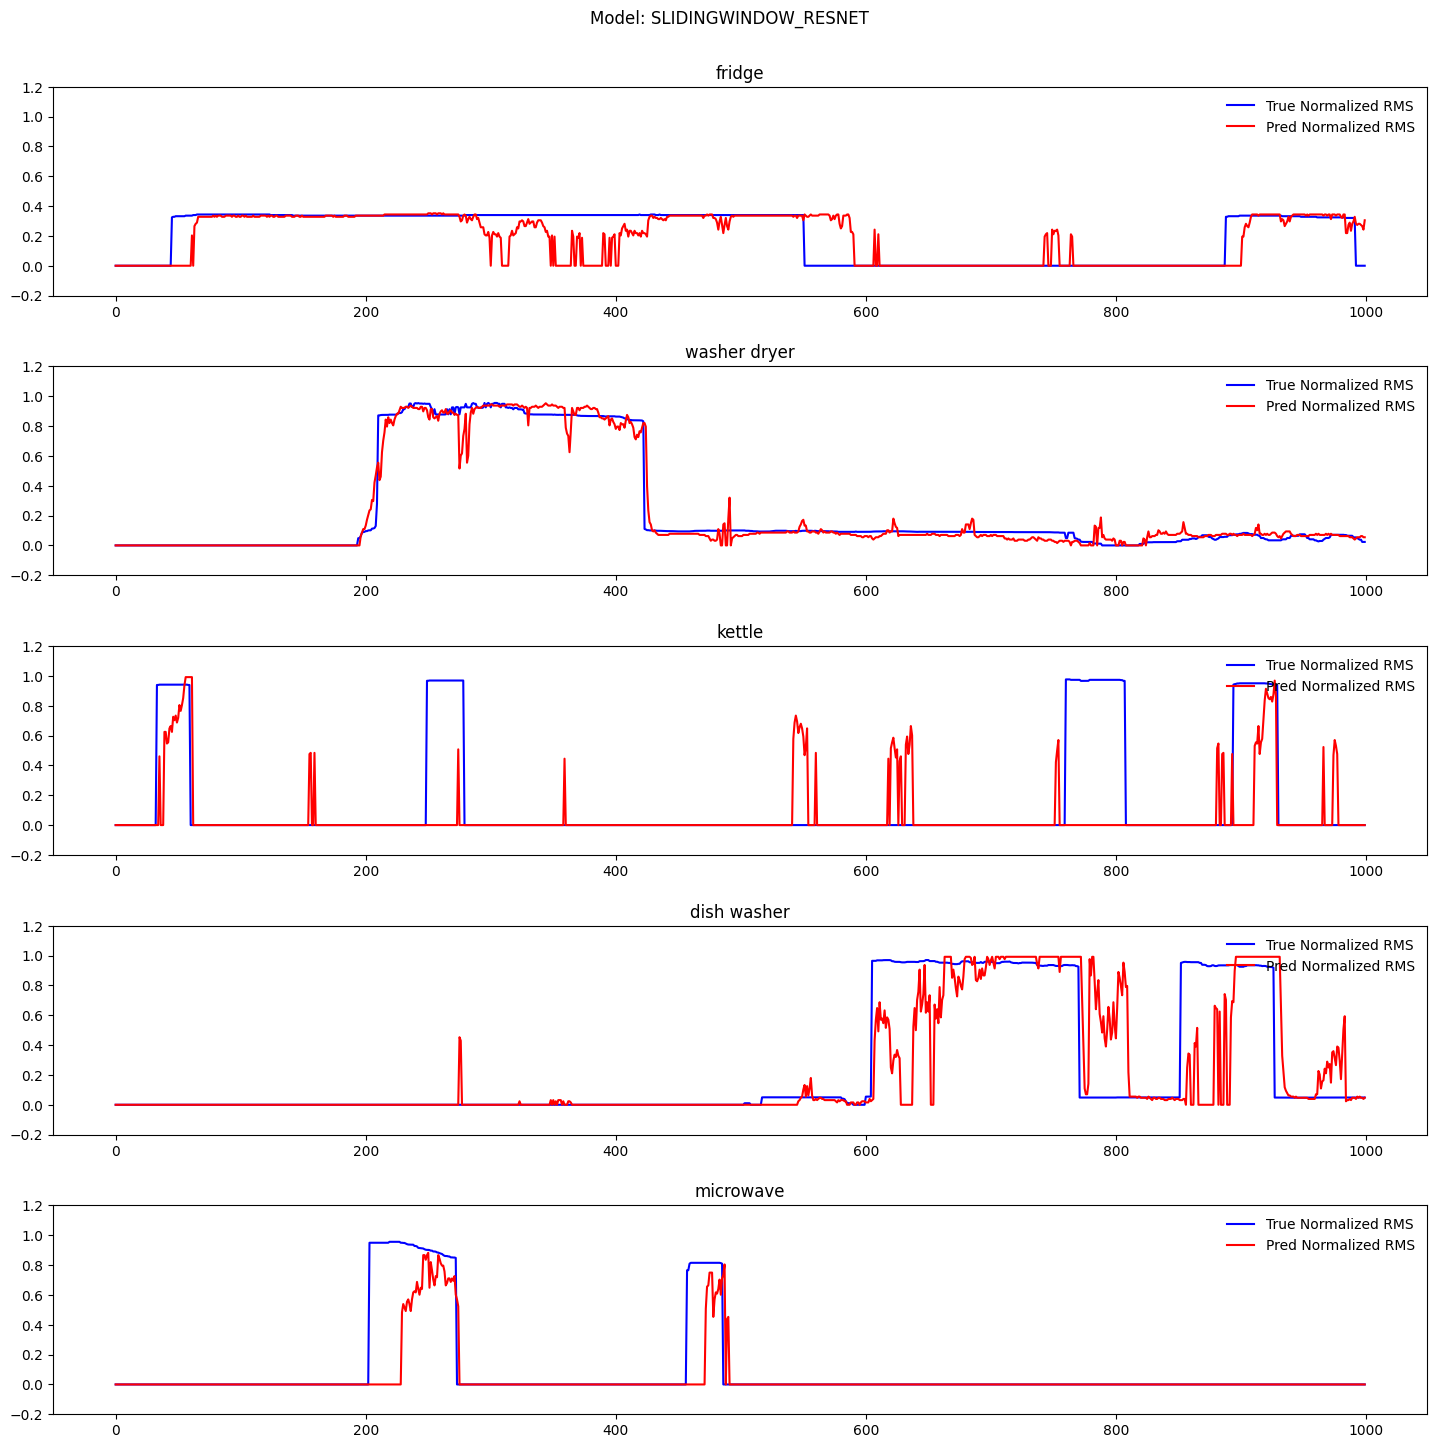

In [41]:
# start = 25500
start = 30500
length = 1000

stacked_pred_rms_ = stacked_pred_rms[start:start+length,:]
stacked_pred_states_ = stacked_pred_states[start:start+length,:]
stacked_states_ = stacked_states[start:start+length,:]
stacked_rms_ = stacked_rms[start:start+length,:]

app_fig, app_axes = plt.subplots(5, figsize=(15, 15))
app_fig.suptitle(f'Model: {MODEL.name}')

app_fig.tight_layout(pad=3)
for i in range(5):
    app_axes[i].plot(stacked_states_[:,i]*stacked_rms_[:,i], 'b', label='True Normalized RMS')
    app_axes[i].plot(stacked_pred_states_[:,i]*stacked_pred_rms_[:,i], 'r', label='Pred Normalized RMS')
    app_axes[i].set_ylim([-0.2, 1.2])
    app_axes[i].legend(loc='upper right', frameon=False)
    app_axes[i].set_title(classes[i])

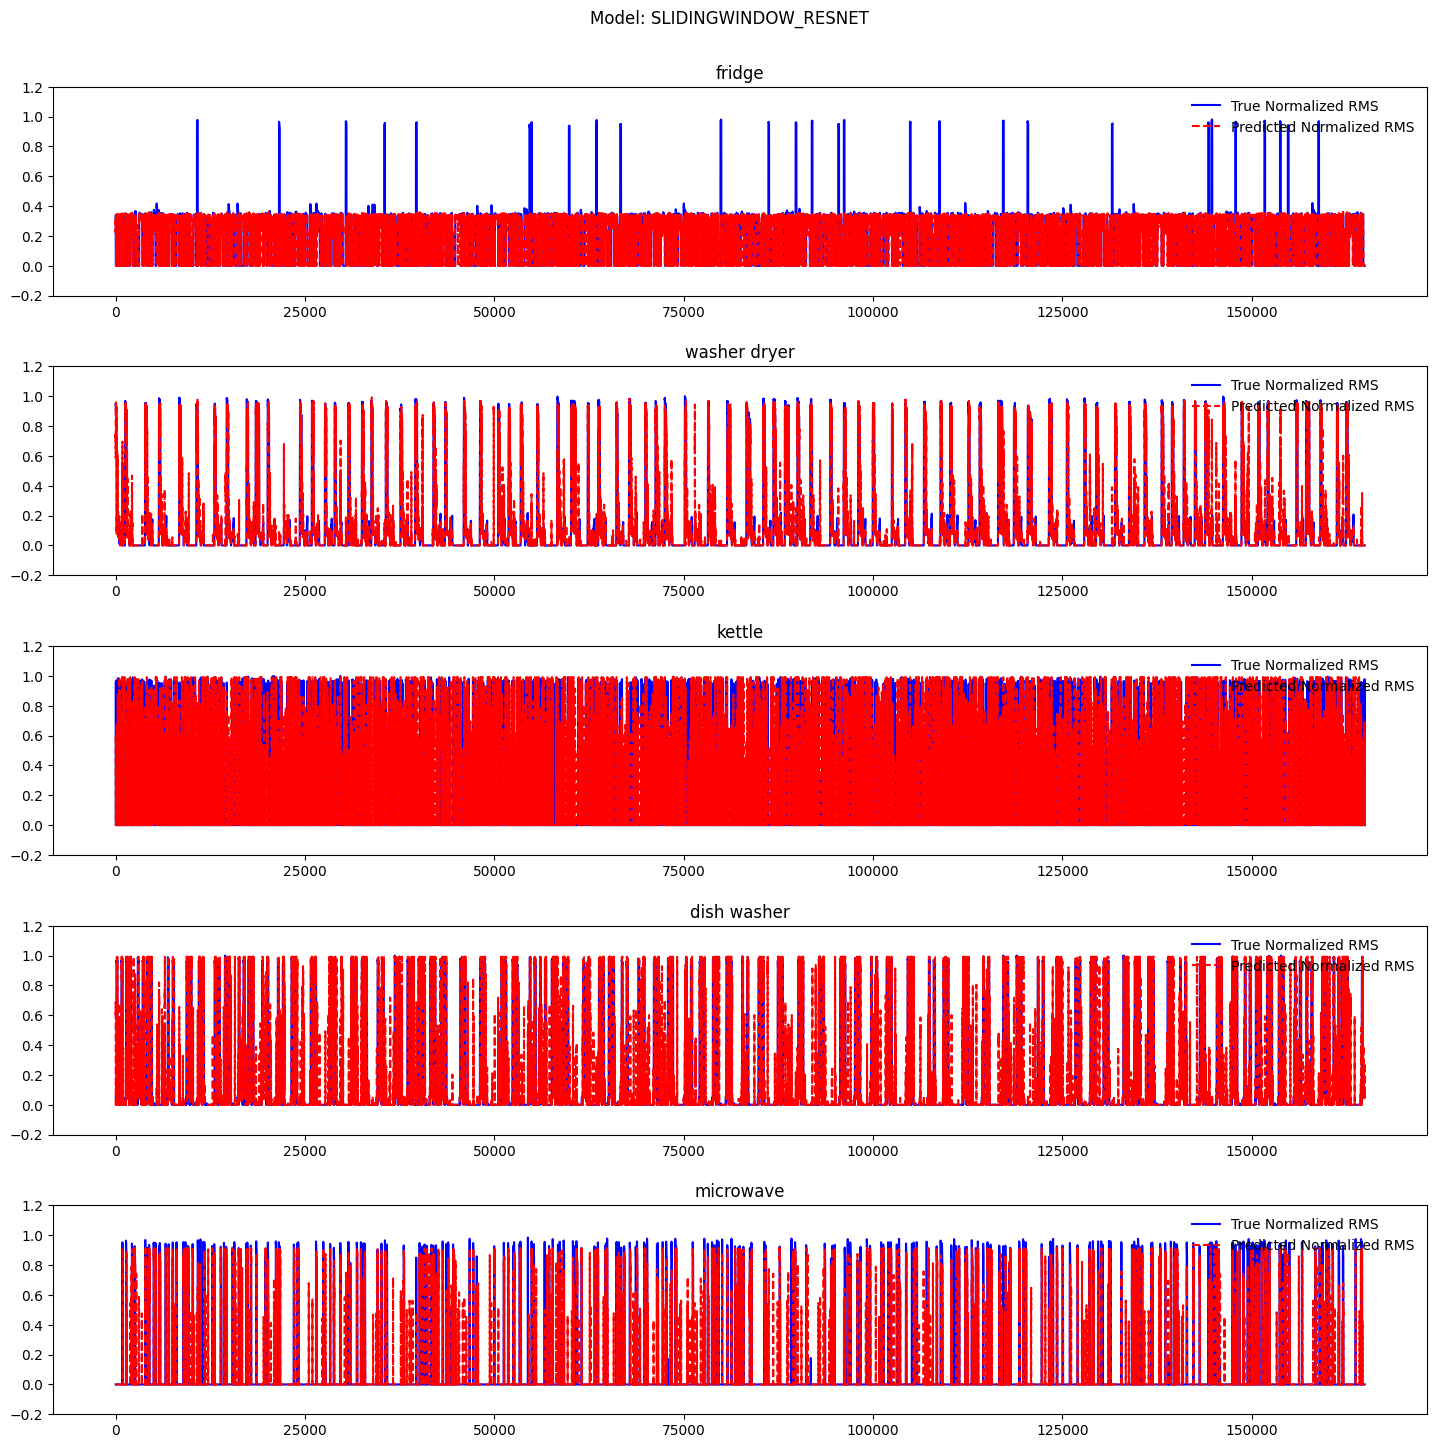

In [42]:
app_fig, app_axes = plt.subplots(5, figsize=(15, 15))
app_fig.suptitle(f'Model: {MODEL.name}')

app_fig.tight_layout(pad=3)
for i in range(5):
    app_axes[i].plot(stacked_states[:,i]*stacked_rms[:,i], 'b', label='True Normalized RMS')
    app_axes[i].plot(stacked_pred_states[:,i]*stacked_pred_rms[:,i], '--r', label='Predicted Normalized RMS')
    app_axes[i].set_ylim([-0.2, 1.2])
    app_axes[i].legend(loc='upper right', frameon=False)
    app_axes[i].set_title(classes[i])

## Recreation of signal

In [43]:
train_set.metadata

{'preprocessing': [{'activation_extension': {'mode': 'randomizer',
    'num_full_samples': 1200000}},
  {'normalization': {'mode': 'minmax', 'scope': 'local'}}],
 'appliances': ['fridge',
  'washer dryer',
  'kettle',
  'dish washer',
  'microwave'],
 'appliance_data': {'fridge': {'window': 50,
   'min': 0.0,
   'max': 259.0,
   'on_power_threshold': 50},
  'washer dryer': {'window': 50,
   'min': 0.0,
   'max': 2055.0,
   'on_power_threshold': 20},
  'kettle': {'window': 50,
   'min': 0.0,
   'max': 2417.0,
   'on_power_threshold': 10},
  'dish washer': {'window': 10,
   'min': 0.0,
   'max': 2439.0,
   'on_power_threshold': 10},
  'microwave': {'window': 50,
   'min': 0.0,
   'max': 1605.0,
   'on_power_threshold': 200}}}

In [44]:
def denormalize(signal, minimum, maximum):
        return signal * (maximum - minimum) + minimum

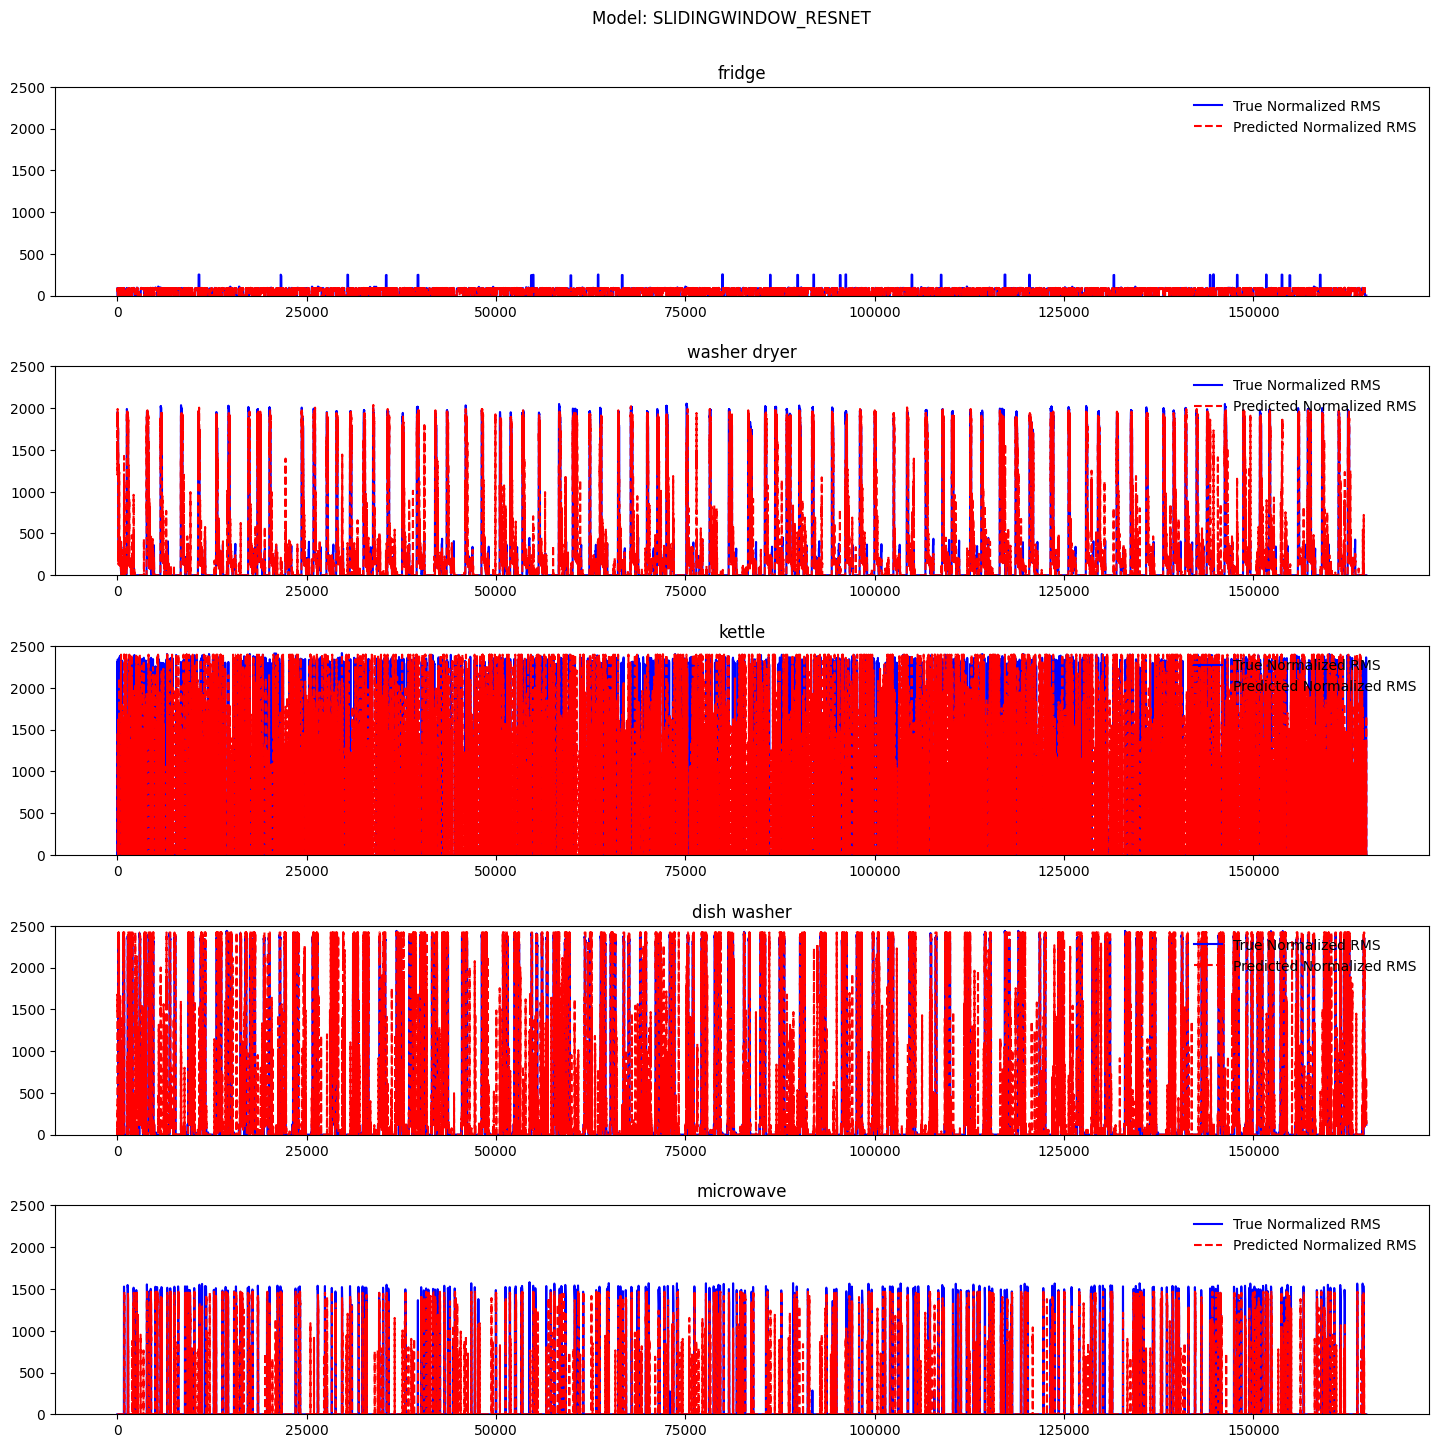

In [45]:
metadata = train_set.metadata

app_fig, app_axes = plt.subplots(5, figsize=(15, 15))
app_fig.suptitle(f'Model: {MODEL.name}')

app_fig.tight_layout(pad=3)
for i in range(5):
    true_signal = denormalize(stacked_states[:,i]*stacked_rms[:,i],
                              minimum=metadata["appliance_data"][classes[i]]['min'],
                              maximum=metadata["appliance_data"][classes[i]]['max'])
    pred_signal = denormalize(stacked_pred_states[:,i]*stacked_pred_rms[:,i],
                              minimum=metadata["appliance_data"][classes[i]]['min'],
                              maximum=metadata["appliance_data"][classes[i]]['max'])
    app_axes[i].plot(true_signal, 'b', label='True Normalized RMS')
    app_axes[i].plot(pred_signal, '--r', label='Predicted Normalized RMS')
    app_axes[i].set_ylim([0, 2500])
    app_axes[i].legend(loc='upper right', frameon=False)
    app_axes[i].set_title(classes[i])

In [46]:
import matplotlib.patches as mpatches

In [47]:
# start = 25500
start = 30200
length = 1000
y_max = 2500

Text(0.5, 1.0, 'Normalized RMS Input')

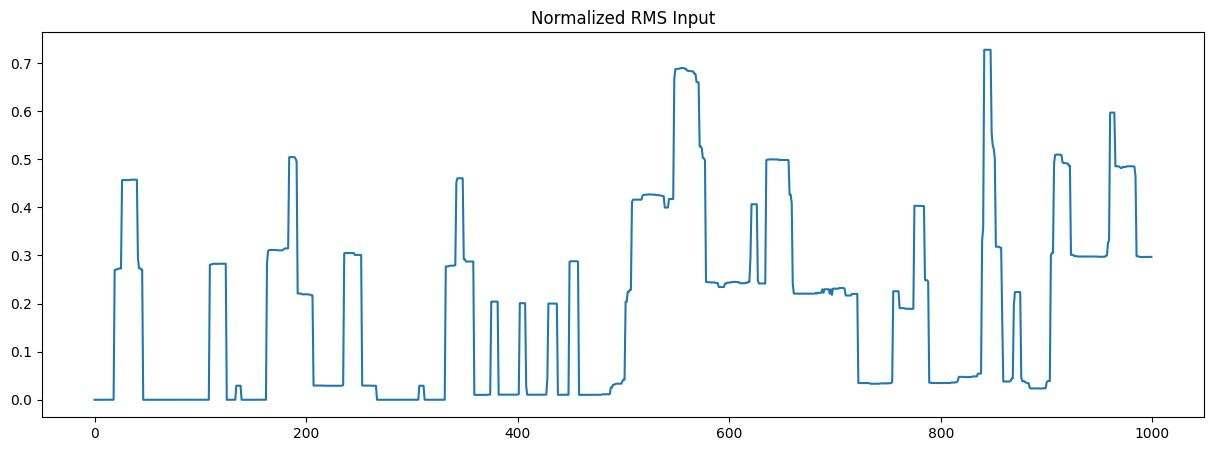

In [48]:
raw_input = TESTSET.data[start+100:start+100+length]
plt.figure(figsize=(15, 5))
plt.plot(raw_input)
plt.title("Normalized RMS Input")

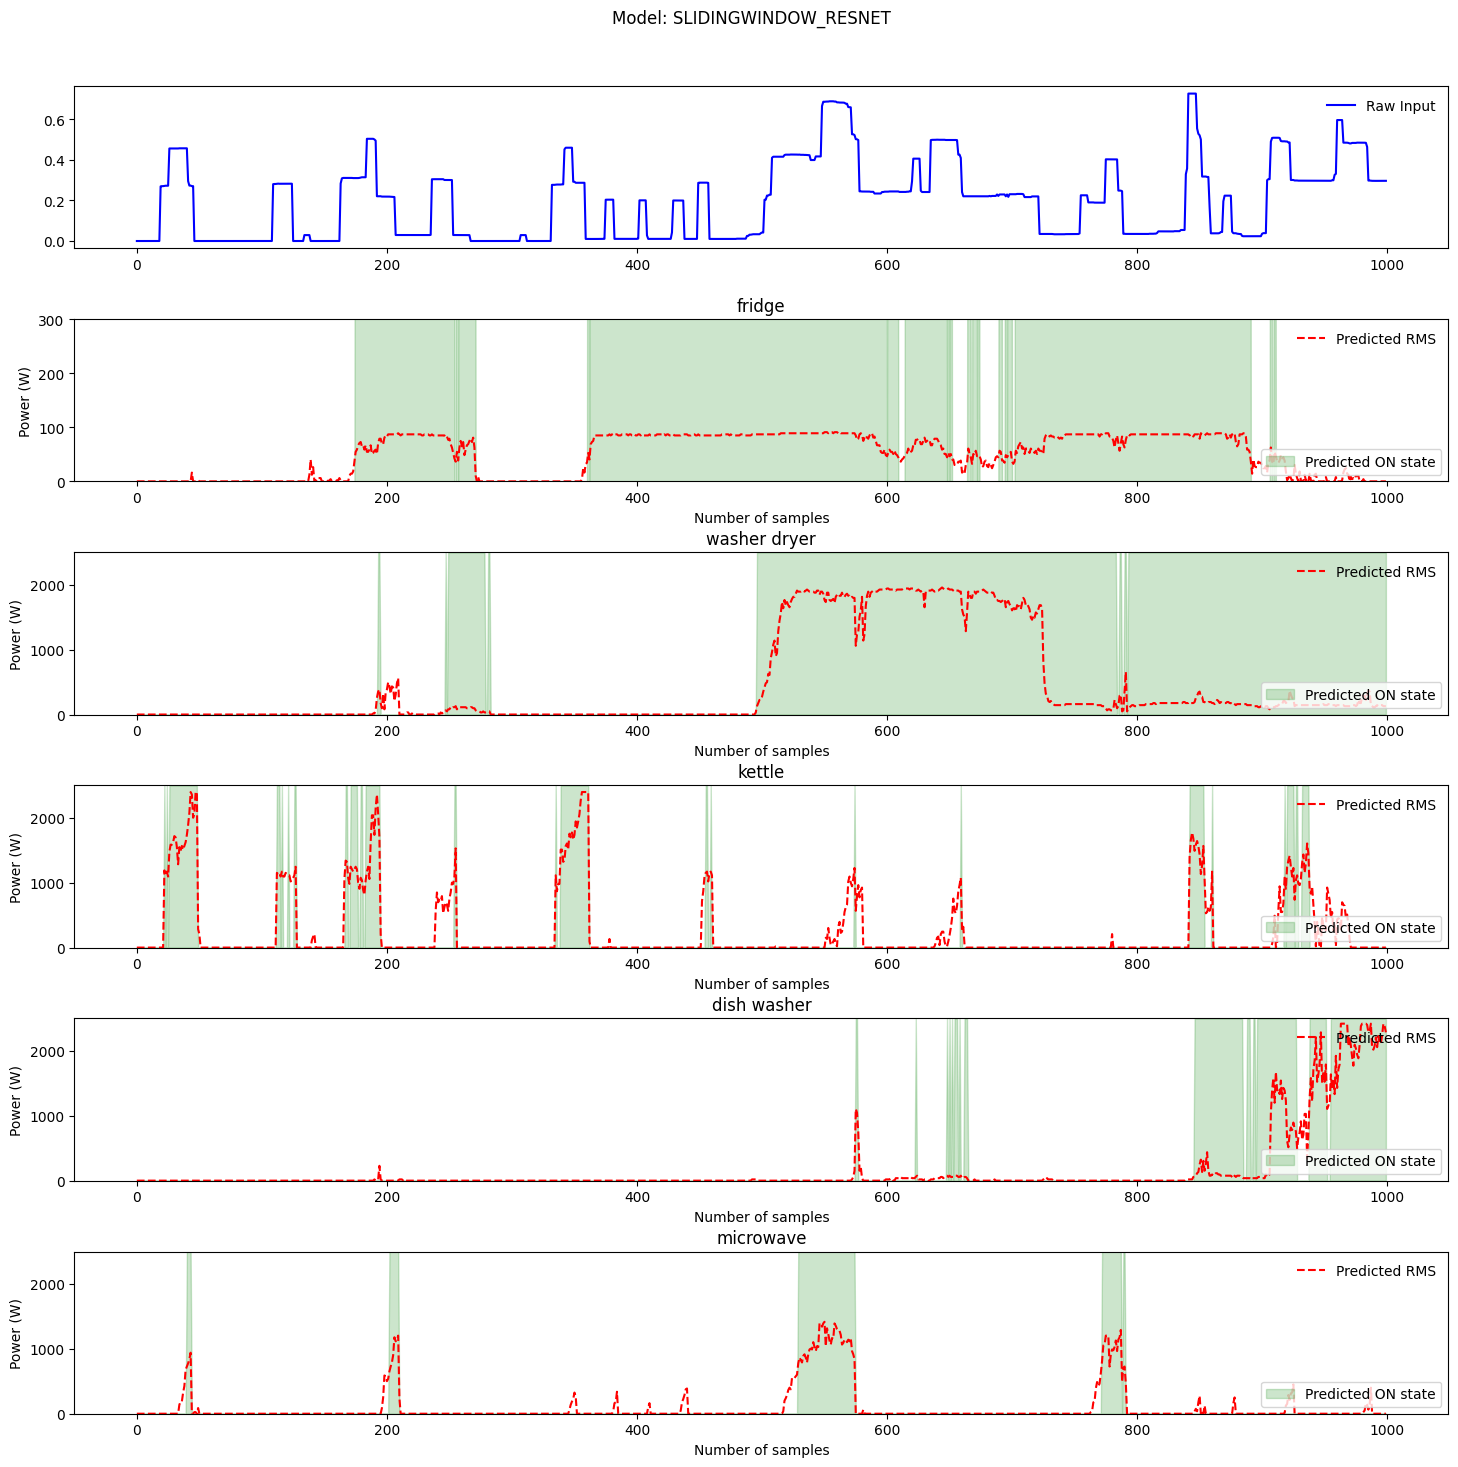

In [53]:
stacked_pred_rms_ = stacked_pred_rms[start:start+length,:]
stacked_pred_states_ = stacked_pred_states[start:start+length,:]
stacked_states_ = stacked_states[start:start+length,:]
stacked_rms_ = stacked_rms[start:start+length,:]

app_fig, app_axes = plt.subplots(6, figsize=(15, 15))
app_fig.suptitle(f'Model: {MODEL.name}')

app_fig.tight_layout(pad=3)

blue_patch = mpatches.Patch(color='green', label='Predicted ON state', alpha=0.2)

app_axes[0].plot(raw_input, 'b', label='Raw Input')
app_axes[0].legend(loc='upper right', frameon=False)

for i in range(5):
    # pred_signal = denormalize(stacked_pred_states_[:,i]*stacked_pred_rms_[:,i],
    #                           minimum=metadata["appliance_data"][classes[i]]['min'],
    #                           maximum=metadata["appliance_data"][classes[i]]['max'])
    pred_signal = denormalize(stacked_pred_rms_[:,i],
                              minimum=metadata["appliance_data"][classes[i]]['min'],
                              maximum=metadata["appliance_data"][classes[i]]['max'])
    app_axes[i+1].fill_between(np.arange(0, length, 1), stacked_pred_states_[:,i]*y_max, color='green', alpha=0.2)
    # app_axes[i+1].plot(stacked_pred_states_[:,i]*y_max)
    app_axes[i+1].plot(pred_signal, '--r', label='Predicted RMS')
    if i == 0:
        app_axes[i+1].set_ylim([-0.2, 300])
    else:
        app_axes[i+1].set_ylim([-0.2, y_max])
    first_leg = app_axes[i+1].legend(handles=[blue_patch], loc='lower right')
    app_axes[i+1].add_artist(first_leg)
    app_axes[i+1].legend(loc='upper right', frameon=False)
    app_axes[i+1].set_title(classes[i])
    app_axes[i+1].set_ylabel("Power (W)")
    app_axes[i+1].set_xlabel("Number of samples")

In [50]:
from copy import copy

In [51]:
results = {}
results["state"] = copy(stacked_states)
results["pred_state"] = copy(stacked_pred_states)
results["power"] = copy(stacked_rms)
results["pred_power"] = copy(stacked_pred_rms)
for i, app in enumerate(classes):
        results["power"][:,i] = denormalize(results["power"][:,i],
                                       minimum=metadata["appliance_data"][app]['min'],
                                       maximum=metadata["appliance_data"][app]['max'])
        results["pred_power"][:,i] = denormalize(results["pred_power"][:,i],
                                       minimum=metadata["appliance_data"][app]['min'],
                                       maximum=metadata["appliance_data"][app]['max'])

In [52]:
np.save("results_resnet_sliding_window.npy", results, allow_pickle=True)
del results